In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

In [2]:
from google.colab import files
uploaded = files.upload()

Saving prison_dataset.csv to prison_dataset.csv


In [3]:
df=pd.read_csv('prison_dataset.csv')
df.head()

,Fiscal Year Released,Recidivism Reporting Year,Race - Ethnicity,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Main Supervising District,Release Type,Part of Target Population,Recidivism - Return to Prison numeric
0,2010,2013,White,<45,D Felony,Violent,Other,3JD,Parole,Yes,1
1,2010,2013,White,>45,D Felony,Other,Other,3JD,Parole,Yes,1
2,2010,2013,White,<45,D Felony,Other,Other,5JD,Parole,Yes,1
3,2010,2013,White,>45,Other Felony,Drug,Trafficking,3JD,Parole,Yes,1
4,2010,2013,Black,<45,D Felony,Drug,Trafficking,3JD,Parole,Yes,1


In [4]:
def entropy(target_col):
    """
    Calculate the entropy of a dataset.
    The only parameter of this function is the target_col parameter which specifies the target column
    """
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy


In [5]:
def InfoGain(data,split_attribute_name,target_name="cond"):
    """
    Calculate the information gain of a dataset. This function takes three parameters:
    1. data = The dataset for whose feature the IG should be calculated
    2. split_attribute_name = the name of the feature for which the information gain should be calculated
    3. target_name = the name of the target feature. The default for this example is "class"
    """    
    #Calculate the entropy of the total dataset
    total_entropy = entropy(data[target_name])
    
    ##Calculate the entropy of the dataset
    
    #Calculate the values and the corresponding counts for the split attribute 
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    
    #Calculate the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    
    #Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain

In [6]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [50]:
X_random=df.sample(frac=1)
X_tr=X_random[:int(len(df)*0.8)]
X_ts=X_random[int(len(df)*0.8):]

In [51]:
X_tr=X_tr.reset_index(drop=True)
X_ts=X_ts.reset_index(drop=True)

In [52]:
def ID3(data,originaldata,features,target_attribute_name="Recidivism - Return to Prison numeric",parent_node_class = None,J=[],ct=[],current_depth=0,max_depth=6,j=None,depth_mode=True):
    
    #print("j : {}".format(j))#Define the stopping criteria --> If one of this is satisfied, we want to return a leaf node#
    #print("current depth : {}".format(current_depth))
    J.append(j)
    ct.append(current_depth)
    #If all target_values have the same value, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
      #print("current depth : {}".format(current_depth))
      return np.unique(data[target_attribute_name])[0]
    
    #If the dataset is empty, return the mode target feature value in the original dataset
    elif len(data)==0:
      #print("current depth : {}".format(current_depth))
      return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    
    #If the feature space is empty, return the mode target feature value of the direct parent node --> Note that
    #the direct parent node is that node which has called the current run of the ID3 algorithm and hence
    #the mode target feature value is stored in the parent_node_class variable.
    
    elif len(features) ==0 : 
      #print("current depth : {}".format(current_depth))
      return parent_node_class
    
    #If none of the above holds true, grow the tree!
    elif (depth_mode and current_depth==max_depth):
      return data[target_attribute_name].mode()[0]
    else:
        #Set the default value for this node --> The mode target feature value of the current node
        #parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        #print(data)
        parent_node_class = data[target_attribute_name].mode()[0]
        #print("P-node : {}".format(parent_node_class))
        #Select the feature which best splits the dataset
        best_feature  = features[np.argmax([InfoGain(data,feature,target_attribute_name) for feature in features])] #Return the information gain values for the features in the dataset   
        #print("NU= {}".format(nu))     
        #Create the tree structure. The root gets the name of the feature (best_feature) with the maximum information
        #gain in the first run
        
        tree = {best_feature:{}}
        #print("tree : {}".format(tree))
        
        #Remove the feature with the best inforamtion gain from the feature space
        features = [i for i in features if i != best_feature]
        
        #print("len feature : {}".format(len(features)))
        #if

        #Grow a branch under the root node for each possible value of the root node feature
        for j,value in enumerate(np.unique(data[best_feature])):
          #print("This is best-feature : {}".format(best_feature))
          if j==0:
            current_depth+=1
          #print("This is value : {}".format(value))
          #print("j : {}".format(j))
          #Split the dataset along the value of the feature with the largest information gain and therwith create sub_datasets
          sub_data = data[data[best_feature] == value]
            
          #Call the ID3 algorithm for each of those sub_datasets with the new parameters --> Here the recursion comes in!
          #print(i)  
          
          subtree = ID3(sub_data,data,features,target_attribute_name,parent_node_class,J,ct,current_depth,max_depth,j)
          
          #print("This is subtree : {}".format(subtree))
            #Add the sub tree, grown from the sub_dataset to the tree under the root node
          tree[best_feature][value] = subtree
          #print("this is tree : {}".format(tree))
        return tree
          
                


In [22]:
Q=X_ts.iloc[0].drop("Recidivism - Return to Prison numeric").to_dict()
Q

{'Age At Release': '<45',
 'Convicting Offense Classification': 'Other Felony',
 'Convicting Offense Subtype': 'Other',
 'Convicting Offense Type': 'Violent',
 'Fiscal Year Released': 2015,
 'Main Supervising District': '5JD',
 'Part of Target Population': 'Yes',
 'Race - Ethnicity': 'White',
 'Recidivism Reporting Year': 2018,
 'Release Type': 'Discharged End of Sentence',
 'predictions': 'NOT Found'}

In [11]:
Q.keys()

dict_keys(['Fiscal Year Released', 'Recidivism Reporting Year', 'Race - Ethnicity', 'Age At Release', 'Convicting Offense Classification', 'Convicting Offense Type', 'Convicting Offense Subtype', 'Main Supervising District', 'Release Type', 'Part of Target Population'])

In [47]:
def predict(query,tree,default = 'NOT Found'):
        
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return default
            result = tree[key][query[key]]
            if isinstance(result,dict):#check if we have a dictionary -> We have further nodes to investigate
                return predict(query,result)

            else:
                return result
                
def RandomForest_Train(dataset,number_of_Trees):
    #Create a list in which the single forests are stored
    random_forest_sub_tree = []
    
    #Create a number of n models
    for i in range(number_of_Trees):
        #Create a number of bootstrap sampled datasets from the original dataset 
        bootstrap_sample = dataset.sample(frac=1,replace=True)
        
        #Create a training and a testing datset by calling the train_test_split function
        bootstrap_training_data = train_test_split(bootstrap_sample)[0]
        bootstrap_testing_data = train_test_split(bootstrap_sample)[1] 
        
        
        #Grow a tree model for each of the training data
        #We implement the subspace sampling in the ID3 algorithm itself. Hence take a look at the ID3 algorithm above!
        random_forest_sub_tree.append(ID3(bootstrap_training_data,bootstrap_training_data,bootstrap_training_data.drop(labels=["Recidivism - Return to Prison numeric"],axis=1).columns,max_depth=6,depth_mode=True))
        
    return random_forest_sub_tree


        
random_forest = RandomForest_Train(X_tr,3)

 

#######Predict a new query instance###########
def RandomForest_Predict(query,random_forest,default='NOT Found'):
    predictions = []
    for tree in random_forest:
        predictions.append(predict(query,tree,default))
    return sps.mode(predictions)[0][0]



#######Test the model on the testing data and return the accuracy###########
def RandomForest_Test(data,random_forest):
    data['predictions'] = None
    for i in range(len(data)):
        query = data.iloc[i].drop("Recidivism - Return to Prison numeric").to_dict()
        data.loc[i,'predictions'] = RandomForest_Predict(query,random_forest)
    accuracy = sum(data['predictions'] == data["Recidivism - Return to Prison numeric"])/len(data)*100
    #print(classification_report(data["Recidivism - Return to Prison numeric"].values.astype('int'),data['predictions'].values.astype('int')))
    print('The prediction accuracy is: ',accuracy,'%')
    #print(sns.heatmap(confusion_matrix(data["Recidivism - Return to Prison numeric"].values.astype('int'),data['predictions'].values.astype('int')),annot=True))
    return accuracy
        
        

RandomForest_Test(X_ts,random_forest)

The prediction accuracy is:  72.70664505672609 %


72.70664505672609

The prediction accuracy is:  72.38249594813614 %
The prediction accuracy is:  72.25283630470017 %
The prediction accuracy is:  72.22042139384118 %
The prediction accuracy is:  72.51215559157212 %
The prediction accuracy is:  71.9935170178282 %
The prediction accuracy is:  72.15559157212319 %
The prediction accuracy is:  72.35008103727715 %
[72.38249594813614, 72.25283630470017, 72.22042139384118, 72.51215559157212, 71.9935170178282, 72.15559157212319, 72.35008103727715]


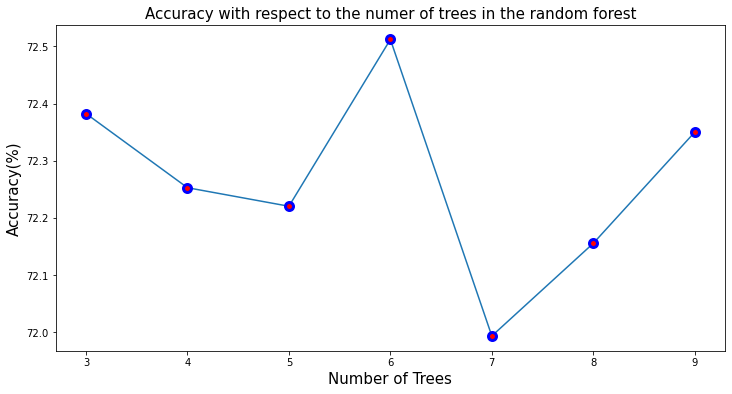

In [53]:
fig = plt.figure(figsize=(12,6))
accuracy=[]
for i in range(3,10,1):
    random_forest = RandomForest_Train(X_tr,i)
    accuracy.append(RandomForest_Test(X_ts,random_forest))

print(accuracy)
plt.plot(np.arange(3,10,1),accuracy,marker='o',markeredgecolor="b",markerfacecolor="r",ms=8,markeredgewidth=3)
#ax0.set_yticks(np.linspace(50,100,50))
plt.title("Accuracy with respect to the numer of trees in the random forest",size=15)
plt.xlabel("Number of Trees",size=15)
plt.ylabel('Accuracy(%)',size=15)

plt.show()

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score

In [186]:
le=preprocessing.LabelEncoder()

In [187]:
model = RandomForestClassifier(max_depth=3,n_estimators=4,random_state=0,criterion='entropy')

In [188]:
df_rand=df.sample(frac=1,replace=True)

In [189]:
X=df_rand.drop("Recidivism - Return to Prison numeric",axis=1)
y=df_rand["Recidivism - Return to Prison numeric"]

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [191]:
X_train_encode=np.array([le.fit_transform(col) for col in X_train.values.T]).T
X_test_encode=np.array([le.fit_transform(col) for col in X_test.values.T]).T
X_train_encode

array([[1, 1, 1, ..., 0, 0, 0],
       [2, 2, 1, ..., 0, 1, 1],
       [2, 2, 1, ..., 0, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 0, 0]])

In [192]:
model.fit(X_train_encode,y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=4,
                       random_state=0)

In [193]:
preds = model.predict(X_test_encode)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1945
           1       0.70      0.81      0.75      1911

    accuracy                           0.73      3856
   macro avg       0.74      0.73      0.73      3856
weighted avg       0.74      0.73      0.73      3856

0.7310684647302904


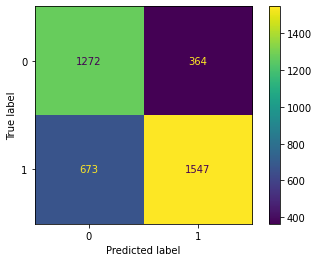

In [178]:
plot_confusion_matrix(model,X_test_encode,y_test)
print(classification_report(preds,y_test))
print(accuracy_score(y_test,preds))

0.7289937759336099
0.729253112033195
0.7300311203319502
0.7318464730290456
0.7318464730290456
0.7313278008298755
0.7331431535269709
0.7323651452282157
0.7318464730290456
0.7318464730290456
0.7323651452282157
0.7326244813278008
0.7323651452282157
0.7331431535269709
0.7321058091286307
0.7323651452282157
0.7308091286307054


Text(0.5, 1.0, 'Accuracy with respect to the Numebr of trees in Random forest')

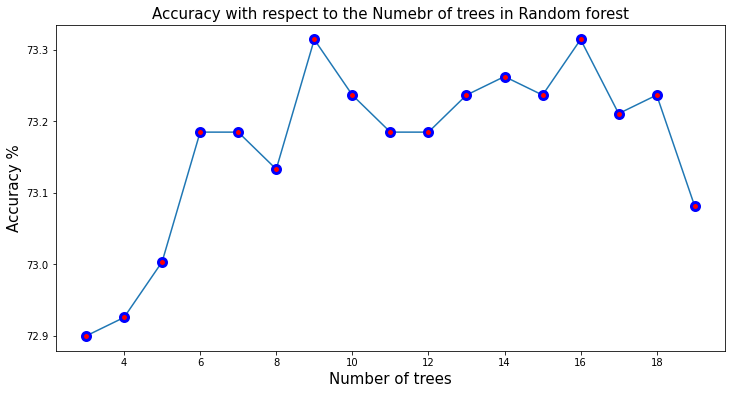

In [184]:
plt.figure(figsize=(12,6))
acc=[]
for i in range(3,20,1):
  model = RandomForestClassifier(max_depth=6,n_estimators=i,random_state=0,criterion='entropy')
  model.fit(X_train_encode,y_train)
  preds = model.predict(X_test_encode)
  print(accuracy_score(y_test,preds))
  acc.append(accuracy_score(y_test,preds)*100)
plt.plot(np.arange(3,20,1),acc,marker='o',markeredgecolor="b",markerfacecolor="r",ms=8,markeredgewidth=3)
plt.xlabel('Number of trees',size=15)
plt.ylabel('Accuracy %',size=15)
plt.title('Accuracy with respect to the Numebr of trees in Random forest',size=15)

In [194]:
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Feature Importance']).sort_values('Feature Importance',ascending=False)

,Feature Importance
Fiscal Year Released,0.478419
Recidivism Reporting Year,0.395111
Part of Target Population,0.052799
Release Type,0.027319
Age At Release,0.021852
Main Supervising District,0.015571
Convicting Offense Type,0.007629
Convicting Offense Classification,0.000661
Convicting Offense Subtype,0.000639
Race - Ethnicity,0.000000
